## Импорт библиотек

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt

## Загрузка данных

In [ ]:
!unzip -qq cats.zip 

replace cats/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
DATA_DIR = './cats/'

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_data = ImageFolder(DATA_DIR, transform=transforms.Compose([
                                                         transforms.Resize(image_size),
                                                         transforms.CenterCrop(image_size),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(*stats)
                                                         ]))

In [ ]:
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Визуализация**

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=32):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


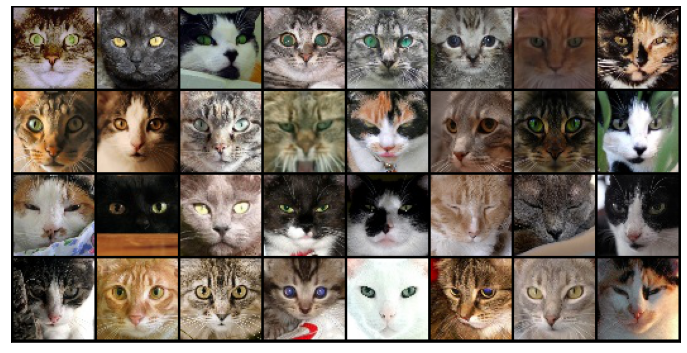

In [ ]:
show_batch(train_loader)

## GAN

![image](https://drive.google.com/uc?export=view&id=1qxWxmGskh1mQCCFTZjg6TFLyp1PMNEkl)

### Генератор

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim=128):
        super(Generator, self).__init__()

        self.image_shape = (3,64,64)
       
        self.model = nn.Sequential(
                        nn.Linear(z_dim,128,bias=True),
                        nn.LeakyReLU(0.2,inplace=True),
                        nn.Linear(128,256,bias=True),
                        nn.LeakyReLU(0.2,inplace=True),
                        nn.Linear(256,512,bias=True),
                        nn.LeakyReLU(0.2,inplace=True),
                        nn.Linear(512,1024,bias=True),
                        nn.LeakyReLU(0.2,inplace=True),
                        nn.Linear(1024,2048,bias=True),
                        nn.LeakyReLU(0.2,inplace=True),
                        nn.Linear(2048,int(np.prod(self.image_shape))),
                        nn.Tanh()
                    )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.image_shape)
        return img

### Дискриминатор

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.image_shape = (3,64,64)
        self.model = nn.Sequential(
                            nn.Linear(int(np.prod(self.image_shape)), 1024),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(1024,512),
                            nn.LeakyReLU(0.2,inplace=True),
                            nn.Linear(512, 256),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256, 1),
                            nn.Sigmoid()
                    )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        output = self.model(img_flat)
        return output

## Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
epochs = 15
lr = 0.0002
batch_size = 64
loss = nn.BCELoss()

In [ ]:
fixed_noise = torch.randn(16,128,device=device)

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
def generate_images(fakes,image_folder):
    # Фунцкция для создания сетки и сохранения изображений
    image_grid = make_grid(fakes.to(device),padding=2,nrow=4,normalize=True)
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)
    save_image(image_grid,'{}/img_{}.png'.format(image_folder,epoch))

In [ ]:
losses_g = []
losses_d = []


for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # Обучаем дискриминатор
        # Real inputs - реальные картинки из Cats
        # Fake inputs - выход генератора
        # Real inputs должны быть классифицированы как 1, fake - 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Обучаем генератор
        # Цель генератора - заставить дискриминатор верить, что все картинки класса 1
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        # Пытаемся обмануть дискриминатор
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Сохраняем лосс генератора и дискриминатора
        losses_g.append(G_loss)
        losses_d.append(D_loss)


        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

        # Сохраним сгенерированные изображения
        with torch.no_grad():
          fakes = G(fixed_noise)
          image_folder = './generated_images'
          generate_images(fakes,image_folder)

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 Iteration 100: discriminator_loss 0.403 generator_loss 0.797
Epoch 0 Iteration 124: discriminator_loss 0.897 generator_loss 0.119
Epoch 1 Iteration 100: discriminator_loss 0.217 generator_loss 1.389
Epoch 1 Iteration 124: discriminator_loss 0.367 generator_loss 0.977
Epoch 2 Iteration 100: discriminator_loss 0.438 generator_loss 0.944
Epoch 2 Iteration 124: discriminator_loss 0.264 generator_loss 0.766
Epoch 3 Iteration 100: discriminator_loss 0.330 generator_loss 1.907
Epoch 3 Iteration 124: discriminator_loss 0.298 generator_loss 0.601
Epoch 4 Iteration 100: discriminator_loss 0.341 generator_loss 1.934
Epoch 4 Iteration 124: discriminator_loss 0.091 generator_loss 3.565
Epoch 5 Iteration 100: discriminator_loss 0.412 generator_loss 1.783
Epoch 5 Iteration 124: discriminator_loss 0.145 generator_loss 3.476
Epoch 6 Iteration 100: discriminator_loss 0.285 generator_loss 2.656
Epoch 6 Iteration 124: discriminator_loss 0.197 generator_loss 3.096
Epoch 7 Iteration 100: discriminat

In [ ]:
from IPython.display import Image

In [ ]:
!ls ./generated_images

img_0.png   img_12.png	img_1.png  img_4.png  img_7.png
img_10.png  img_13.png	img_2.png  img_5.png  img_8.png
img_11.png  img_14.png	img_3.png  img_6.png  img_9.png


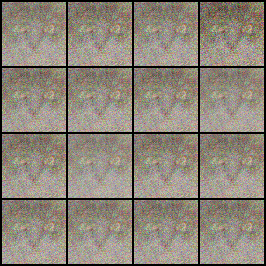

In [ ]:
Image('./generated_images/img_0.png')

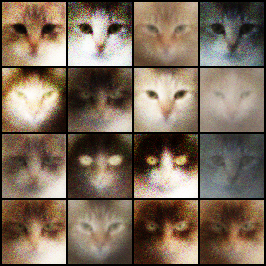

In [ ]:
Image('./generated_images/img_9.png')

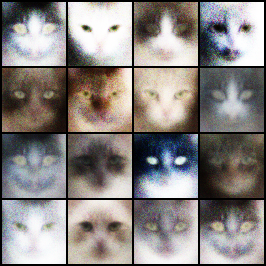

In [ ]:
Image('./generated_images/img_14.png')

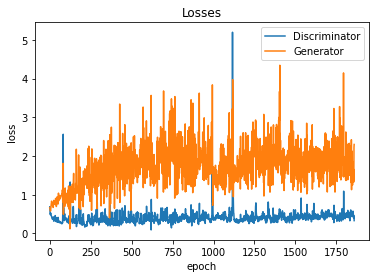

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');